# AdventureWorks Sales Analysis
In this analysis I will examine the AdventureWorks2025-database to answer business questions like:
- Product categories and their sales
- Sales trends over time
- Regional sales
- Option A: Reginal Sales Optimization for the VG part

I will use SQL to retrieve data and Python for visualization and analysis.


In [33]:
import pandas as pd 
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")

user = "SA"
password = quote_plus("Rallelek123")
server = 'localhost:1433'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Connection to the database was successful!")
except Exception as e:
    print("There was an error", e)

def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)
    
DATA_DIR = Path("..") / "data"

def read_sql_file(filename: str) -> str:
    return (DATA_DIR / filename).read_text(encoding="utf-8")

def sek(x, pos):
    return f"{x:,.0f} SEK".replace(",", " ")

sek_formatter = FuncFormatter(sek)

def add_bar_labels(ax, fmt="{:,.0f}", pad=3):
    for c in ax.containers:
        ax.bar_label(c, fmt=fmt, padding=pad)

def add_bar_labels_simple(bars, ax, fmt="{:,.0f}", pad=3):
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, h + pad, fmt.format(h), 
                ha='center', va='bottom')

Connection to the database was successful!


C:\Users\Ralle\AppData\Local\Temp\ipykernel_19608\1675797830.py:28: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


# Visualisation 1 - Number of products per category
**Business question:** How many products exists in each product category?  
**Method:** Join ProductCategory -> ProductSubcategory -> Product and count distinct products per category.

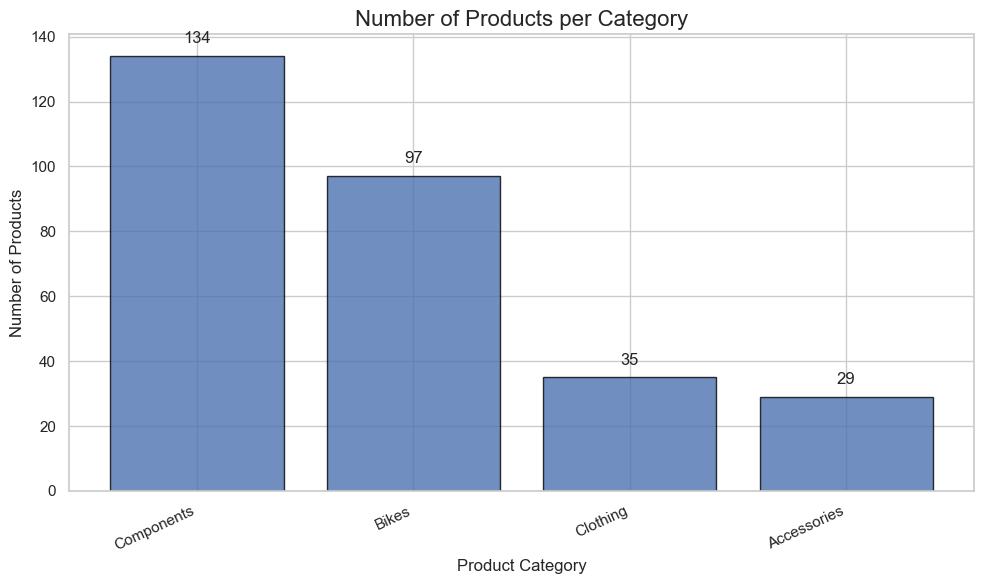

In [34]:
sql = read_sql_file("vis1.sql")
df1 = query_df(sql)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(df1['CategoryName'], df1['TotalProducts'], edgecolor='black', alpha=0.8)

add_bar_labels_simple(bars, ax, fmt="{:,.0f}")
ax.set_title("Number of Products per Category", fontsize=16)
ax.set_xlabel("Product Category", fontsize=12)
ax.set_ylabel("Number of Products", fontsize=12)
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.show()

## Insights
The category with the most products is components with 134 products, while accessories has the fewest with 29 products.  
This indicates that the company is strongly focused on components and spare parts, and that accessories could be an area for improvement/development.

# Visualisation 2 - Total sales per category
**Business question:** Which product categories generate the most revenue?  
**Method:** Join categories to SalesOrderDetail and sum 'LineTotal'. Sorted from highest to lowest.

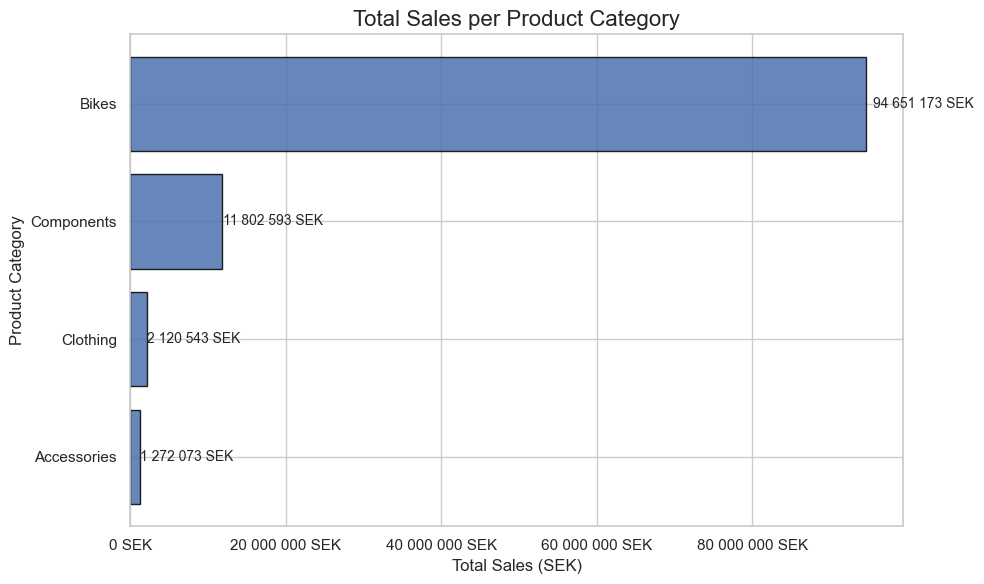

In [35]:
sql = read_sql_file("vis2.sql")
df2 = query_df(sql)

fix, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(df2['CategoryName'][::-1], df2['TotalSales'][::-1], edgecolor='black', alpha=0.85)

for bar in bars:
    width = bar.get_width()
    ax.text(width * 1.01, bar.get_y() + bar.get_height() / 2, f"{width:,.0f} SEK".replace(",", " "), 
            ha='left', va='center', fontsize=10)
    

ax.set_title("Total Sales per Product Category", fontsize=16)
ax.set_xlabel("Total Sales (SEK)", fontsize=12)
ax.set_ylabel("Product Category", fontsize=12)
ax.xaxis.set_major_formatter(sek_formatter)

plt.tight_layout()
plt.show()

## Insights
The top category is Bikes with 94.65 million SEK in revenue. The smallest is Acessories with 1,27 million SEK.

Bikes account for most of the revenue & total sales (aprox 86% of total sales). The 3 other categories only amount to 14% of revenue. This can help prioritize which categories drive most of the business revenue and which could use more attention.

# Visualisation 3 - Monthly sales trend
**Business question:** How has sales developed over time?  
**Method:** Aggregate 'TotalDue' per month from SalesOrderHeader and plot a time series.

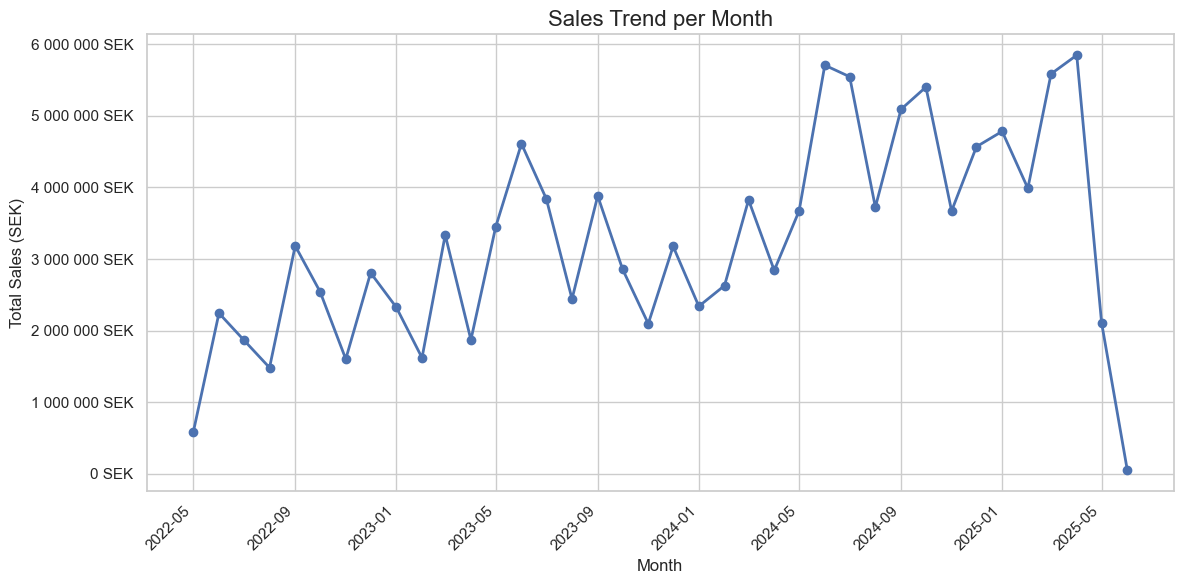

In [36]:
sql = read_sql_file("vis3.sql")
df3 = query_df(sql)

df3['MonthStart'] = pd.to_datetime(df3['MonthStart'])
df3 = df3.sort_values('MonthStart')

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df3['MonthStart'], df3['TotalSales'], marker='o', linewidth=2)

ax.set_title("Sales Trend per Month", fontsize=16)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Total Sales (SEK)", fontsize=12)
ax.yaxis.set_major_formatter(sek_formatter)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Insights
The graph shows a clear upward trend in total monthly sales over time, indicating steady business growth.

Sales start at a relatively low level in mid 2022 and then increase gradually all throughout 2023, with noticeable fluctuations from month to month.
2024 onwards, sales reach consistently higher levels, with several months exceeding 5 million SEK.

There also appears to be a seasonal pattenr, where sales tend to peak during certain periods of the year, followed by temporary declines. The highest monthly sales occur in early 2025, while the lowest values are observed at the beginning of graph in 2022.

# Visualisation 4 - Sales and order count per year (grouped)
**Business question:** How do total sales and number of orders compare per year?  
**Method:** Group SalesOrderHeader by year, calculate total sales and count orders.

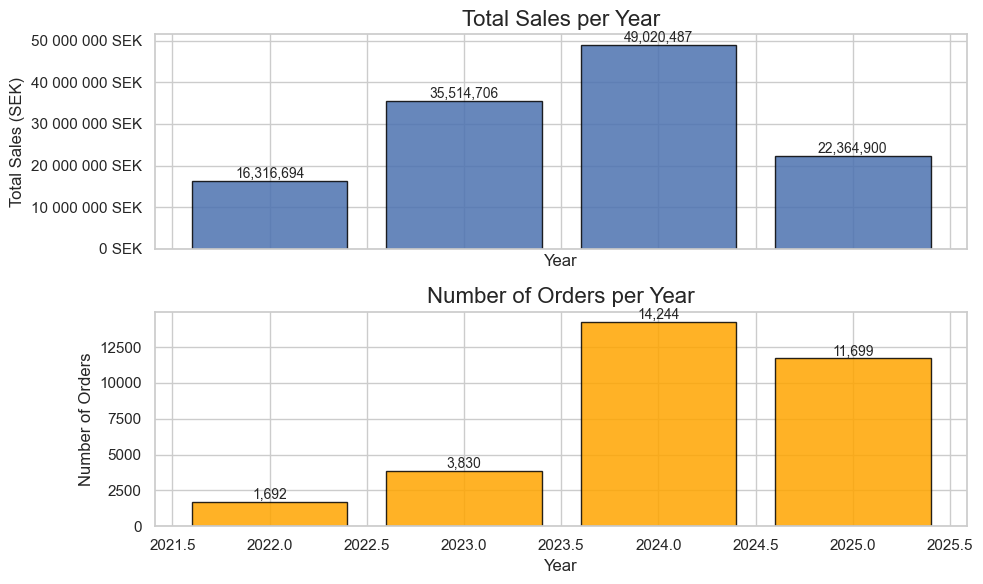

In [37]:
sql = read_sql_file("vis4.sql")
df4 = query_df(sql)
df4 = df4.sort_values('OrderYear')

fig, axes = plt.subplots(2,1,figsize=(10, 6), sharex=True)

#Plot 1
bars_sales = axes[0].bar(df4['OrderYear'], df4['TotalSales'], edgecolor='black', alpha=0.85)

axes[0].set_title("Total Sales per Year", fontsize=16)
axes[0].set_xlabel("Year", fontsize=12)
axes[0].set_ylabel("Total Sales (SEK)")
axes[0].yaxis.set_major_formatter(sek_formatter)

for bar in bars_sales:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, height, f"{height:,.0f}", ha='center', va='bottom', fontsize=10)

#Plot 2
bars_orders = axes[1].bar(df4['OrderYear'], df4['OrderCount'], color='orange', edgecolor='black', alpha=0.85)

axes[1].set_title("Number of Orders per Year", fontsize=16)
axes[1].set_xlabel("Year", fontsize=12)
axes[1].set_ylabel("Number of Orders", fontsize=12)

for bars in bars_orders:
    height = bars.get_height()
    axes[1].text(bars.get_x() + bars.get_width() / 2, height, f"{height:,.0f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## Insights
- Both total sales and the numbers of orders increase from 2022 to 2024, indicating very strong business growth.  
- 2024 is the strongest year, with bot hthe highest sales (49m SEK) and the highest number of orders (14000).  
- in 2025, total sales decrease despite a relatively high number of orders. This is very likely because 2025 only represents a partial year, not a full 12-month period.  
- Overall, the trend shows that growth in sales is largely driven by an increase in order volume rather than a decrease in demand.

# Visualisation 5 - Top 10 products by sales
**Business question:** Which 10 products generate the most sales?  
**Method:** Sum LineTotal per product in SalesOrderDetail and keep TOP 10.

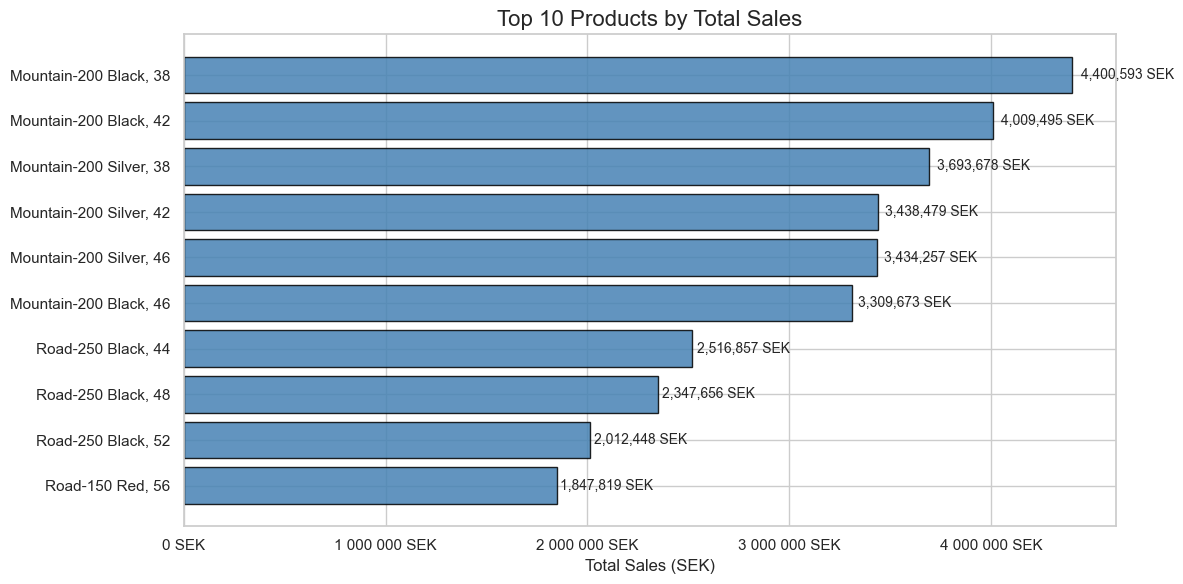

In [38]:
sql = read_sql_file("vis5.sql")
df5 = query_df(sql)

df5 = df5.sort_values('TotalSales', ascending=True)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(df5['ProductName'], df5['TotalSales'], edgecolor='black', alpha=0.85, color="steelblue")

for bar in bars:
    width = bar.get_width()
    ax.text(width * 1.01, bar.get_y() + bar.get_height() / 2, f"{width:,.0f} SEK", va='center', fontsize=10)

ax.set_title("Top 10 Products by Total Sales", fontsize=16)
ax.set_xlabel("Total Sales (SEK)", fontsize=12)
ax.xaxis.set_major_formatter(sek_formatter)

plt.tight_layout()
plt.show()

## Insights
The results of the above graph very clearly shows that all top 10 products belong to the Bikes category, which in turn highlights the strong dominance of bicycles in overall revenue.  
The highest total sales are generated by **Mountain-200 Black, 38,** with a revenue of **4 400 593 SEK,** making it the single most profitable product within this dataset.   
Overall, the **Mountain-200** product line clearly dominates the top-selling products. This suggests that mountain bike models are a key driver of sales performance and should remain a strategic focus for the business going forward.


# Visualisation 6 - Sales and unique customers per region
**Business question:** How does sales differ between regions and how many unique customers does each region have?  
**Method:** Group SalesOrderHeader by territory and compute total sales + unique customers.

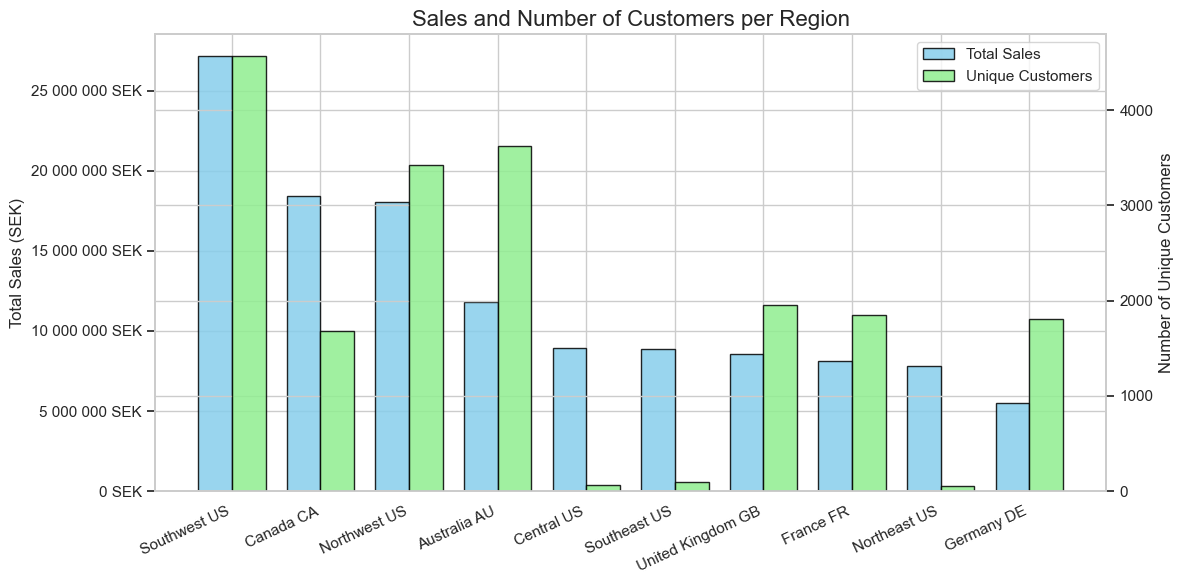

In [39]:
sql = read_sql_file("vis6.sql")
df6 = query_df(sql)

df6 = df6.sort_values('TotalSales', ascending=False)

x = np.arange(len(df6['Region']))
width = 0.38

fig, ax = plt.subplots(figsize=(12, 6))
ax2 = ax.twinx()

bars1 = ax.bar(x - width/2, df6['TotalSales'], width, label='Total Sales', color='skyblue', edgecolor='black', alpha=0.85)
bars2 = ax2.bar(x + width/2, df6['UniqueCustomers'], width, label='Unique Customers', color='lightgreen', edgecolor='black', alpha=0.85)

ax.set_title("Sales and Number of Customers per Region", fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(df6['Region'], rotation=25, ha='right')
ax.set_ylabel("Total Sales (SEK)")
ax2.set_ylabel("Number of Unique Customers")

ax.yaxis.set_major_formatter(sek_formatter)

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()


## Insights
The above graph highlights clear differences between regions both in terms of total sales but also the number of unique customers.  
The **Southwest US** region stands out as the strongest performer, generating the highest total sales while also having the largest customer base. This suggests that sales in this region are driven by a broad and stable group of customers rather than a small number of high-value orders.

Regions such as **Canada CA & Northwest US** also show relatively high total sales, despite having fewer customers compared to the Southwest US. This indicates a higher average ordr value per customer, suggesting that customers in these 2 regions tend to place larger or more expensive orders.

In contrast, regions like **Central, Southeast and Northeast US** have a very low number of unique customers but still generate a noticeable amount of sales. This implies that revenue in these regions is likely dirven b a small number of customers with very high order values. While this can be very profitable, it also introduces a higher business risk if these customers were to reduce or stop doing business.

**Germany DE** appears as one of the weaker regions in terms of total sales, despite having a moderate number of customers. This indicates lower average order values compared to the other regions.

Overall, the analysis shows that regions with many customers tend to provide more stable revenue, while regions with fewer customers but relatively high sales rely on higher order values per customer and may be more sensitive to customer behavior.

# Visualisation 7 - Average order value (AOV) per region and customer type
**Business question:** Which regions have the highest/lowest AOV and does it differ between Store (business) vs Individual customers?  
**Method:** Average order value (AOV) = total sales / number of orders per region. Split by customer type (Store vs Individual).

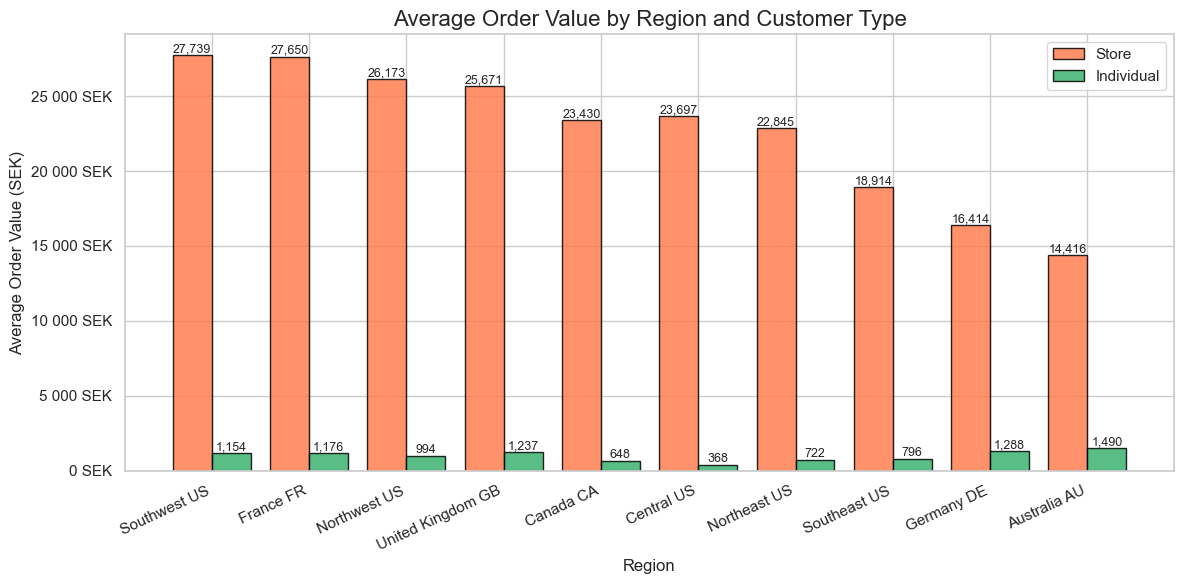

,Region,CustomerType,AvgOrderValue,Orders
9,Southwest US,Store,27739.0649,751
2,Southwest US,Individual,1154.4960,5473
12,France FR,Individual,1176.1834,2484
14,France FR,Store,27649.5197,188
4,Northwest US,Individual,993.8646,4058
11,Northwest US,Store,26172.6823,536
3,United Kingdom GB,Individual,1236.5034,3031
10,United Kingdom GB,Store,25671.3118,188
1,Canada CA,Individual,647.5610,3375
8,Canada CA,Store,23429.7839,692


In [40]:
sql = read_sql_file("vis7.sql")
df7 = query_df(sql)

region_order = (df7.groupby('Region')['AvgOrderValue'].mean().sort_values(ascending=False).index.tolist())

df7['Region'] = pd.Categorical(df7['Region'], categories=region_order, ordered=True)
df7 = df7.sort_values('Region')

fig, ax = plt.subplots(figsize=(12, 6))

types = ["Store", "Individual"]
x = np.arange(len(region_order))
width = 0.4

store_vals = (df7[df7['CustomerType'] == 'Store'].set_index("Region").reindex(region_order)['AvgOrderValue'].to_numpy(dtype=float))
ind_vals = (df7[df7['CustomerType'] == 'Individual'].set_index("Region").reindex(region_order)['AvgOrderValue'].to_numpy(dtype=float))

bars1 = ax.bar(x - width/2, store_vals, width, label='Store', color='coral', edgecolor='black', alpha=0.85)
bars2 = ax.bar(x + width/2, ind_vals, width, label='Individual', color='mediumseagreen', edgecolor='black', alpha=0.85)

ax.set_title("Average Order Value by Region and Customer Type", fontsize=16)
ax.set_xlabel("Region")
ax.set_ylabel("Average Order Value (SEK)")
ax.set_xticks(x)
ax.set_xticklabels(region_order, rotation=25, ha='right')
ax.yaxis.set_major_formatter(sek_formatter)
ax.legend()

def add_labels(bars):
    for b in bars:
        h = b.get_height()
        if np.isnan(h):
            continue
        ax.text(b.get_x() + b.get_width()/2, h, f"{h:,.0f}", ha='center', va='bottom', fontsize=9)

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()

df7

## Insights

Both graphs above show a clear and consistent pattern across all regions: **Store customers (businesses) have a significantly higher average order value compared to Individual customers.**

For Store Customers, the average order value ranges from aproxximately between **14000 and 27700 SEK**, while invidiual customers place much smaller orders, typically between **300 and 1500 SEK**. This indicates very fundamental different purchasing behavior between both customer types.

The difference is consitent across regions, although the absolute levels very.
The highest AOV-value for store customers can be seen in **Southwest US**, making this the most valueable region-customer combination there is in terms of revenue per order.
In contrast, the lowest AOV-values are seen among individual customers, particularly in **Central US.**

These differences can be explained by the fact that store customers typically make fewer but larger purchases, often in bulk or through negotiated agreements beforehand. While individual customers usually make more frequent but smaller purchases.

# Visualisation A - Regional Sales Optimization
**Business question:** How does sales performance differ across regions? Which product categories perform best in each region? Are there identifiable season patterns that can be used to optimize regional sales strategies?  
**Method:** Sales data is aggregated at regional level using the SQL queries in A1-A3 to ensure efficieny and accuracy. The analysis examines:
- Sales distribution across regions and product categories
- Seasonal sales trends per region over time
- Identification of best and weakest performing regions and categories.
Results will be visualised using heatmaps, line charts and bar charts to clearly highlight patterns, differences and opportunities for optimization.

# Visualisation A1 - Sales by Region and Product Catgory (Heatmap)
**Business question:** Which product categories perform best in each region? How does the sales differ geographically?  
**Method:** Sales data is aggregated by region and product category. This is done within the last 12 months to create as relevant data as possible. Sales were aggregated at the region * product category level using LineTotal from order details to capute actual transaction revenue.  
A pivot table is then created in pandas and visualized as a heatmap to clearly compare perfomances across regions.

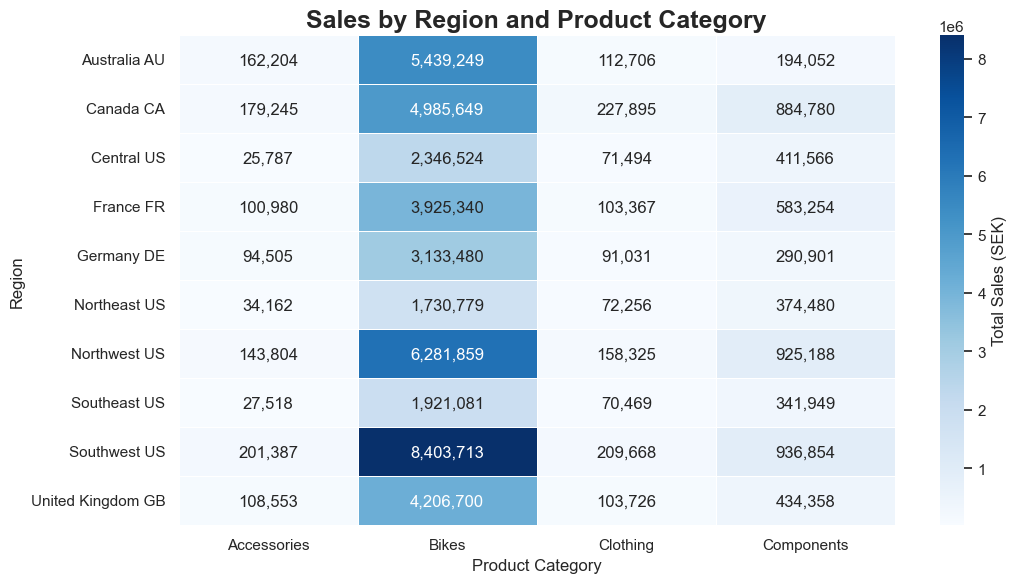

In [41]:
sql = read_sql_file("visA1.sql")
dfA1 = query_df(sql)

pivot = dfA1.pivot_table(index='Region', columns='Category', values='TotalSales', aggfunc='sum').fillna(0)


plt.figure(figsize=(11, 6))
ax = sns.heatmap(pivot, cmap="Blues", annot=True, fmt=",.0f", linewidths=0.5, cbar_kws={'label': 'Total Sales (SEK)'})

plt.title("Sales by Region and Product Category", fontsize=18, fontweight='bold')
plt.xlabel("Product Category", fontsize=12)
plt.ylabel("Region", fontsize=12)
plt.tight_layout()
plt.show()

## Insights
The heatmap shows that like before, **Bikes dominate sales** across all regions. The strongest performance can be seen in the Southwest US, which significantly outperforms other regions, especially in bike sales.  

Regions such as **Northwest US, Canada CA and United Kingdom GB** also show strong bike sales, but at a noticeably lower level than Soutwest US. In stark contrast, **Accessories and Clothing** contribute only marginally to total sales in all regions.

There is no area where the importance of **Components** is comparable to that of bikes, yet there is some regional diversity there, indicating specific demand patterns within specific regions. 

Overall, the data shows a significant reliance on bike sales in all regions, with the Southwest US appearing as the most strategically significant.

# Visualisation A2 - Sales Seasonality per Region
**Business question:** Are there seasonal patterns in sales? Do they differ between regions?  
**Method:** Monthly sales data for the last 12 months are aggregated like before. Sales are grouped by calendar month to identify recurring trends, peaks and dips over time.  
A line chart is then showed to visualize how sales evolve month by month and to allow direct comparison between all regions.

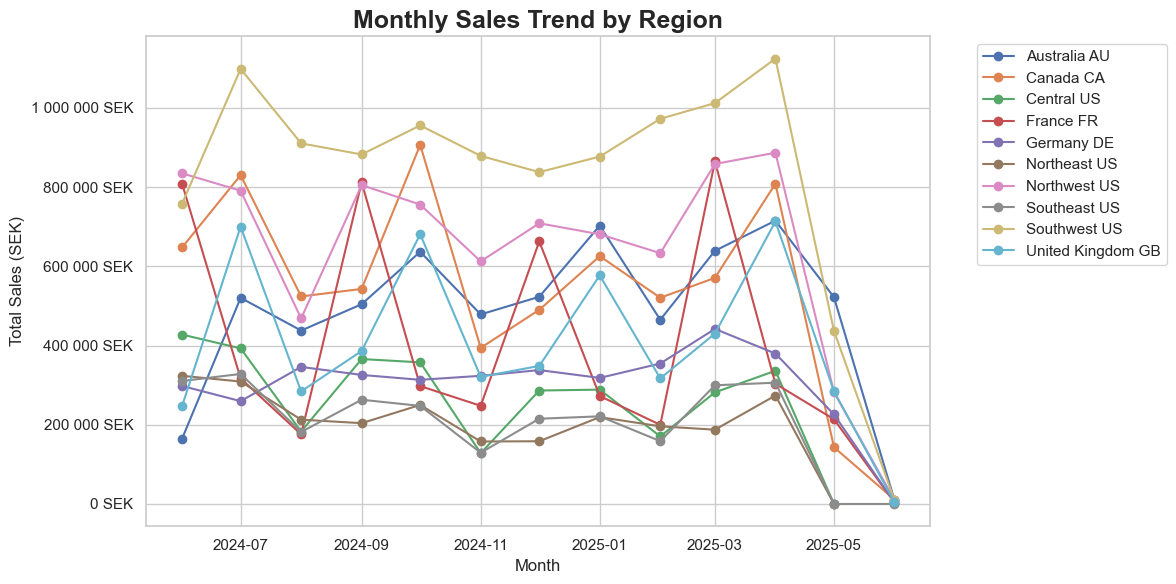

In [42]:
sql = read_sql_file("visA2.sql")
dfA2 = query_df(sql)

dfA2['OrderMonth'] = pd.to_datetime(dfA2['OrderMonth'])
dfA2 = dfA2.sort_values(['Region', 'OrderMonth'])

plt.figure(figsize=(12, 6))

for region in dfA2['Region'].unique():
    region_data = dfA2[dfA2['Region'] == region]
    plt.plot(region_data['OrderMonth'], region_data['TotalSales'], marker='o', label=region)

plt.title("Monthly Sales Trend by Region", fontsize=18, fontweight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Sales (SEK)", fontsize=12)
plt.gca().yaxis.set_major_formatter(sek_formatter)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Insights
**Southwest US** consistenly once again generates the highest monthly sales across the entire 12-month timeframe, which once again indicates that it's the strongest and most stable region for our market. Sales in this region show recurring peaks towards the end of the year and again in early spring, also suggesting seasonal demands.  

Several regions such as **Northwest US, Canada CA and France FR** display noticeable changes in sales patterns over time. Seasonal buying patterns or promotional cycles may be the cause of these regions sporadic sales peaks and brief drops between the months.  

Smaller US regions, such as the **Northeast and Central US** have very similar season patterns, but lower sales levels overall. This does imply that although demand volume varies greatly by region, similar seasonal characteristics may have an impact on the underlying consumer behavior when it comes to sale trends over the 12-month period.  

A sharp decline is very visible in the final month across all regions. This is due to incomplete data for the most recent month, rather than an actual drop in demand (and should therefore be interpreted with caution).  

The graph above contain many regions, which makes the chart visually very dense. This was a deliberate choice to preserve comparability across all regions within a single view. If I were to optimize it, I would filter it or maybe create an interactive version to improve readability further.

# Visualisation A3 - Regional Performance Comparison (Best vs Worst Regions)
**Business question:** Which regions perform best and worst in terms of sales efficiency? And what drives those differences?   
**Method:** Monthly sales data for the last 12 months are aggregated like before. We then compare Total Sales and Average Order Value like before 

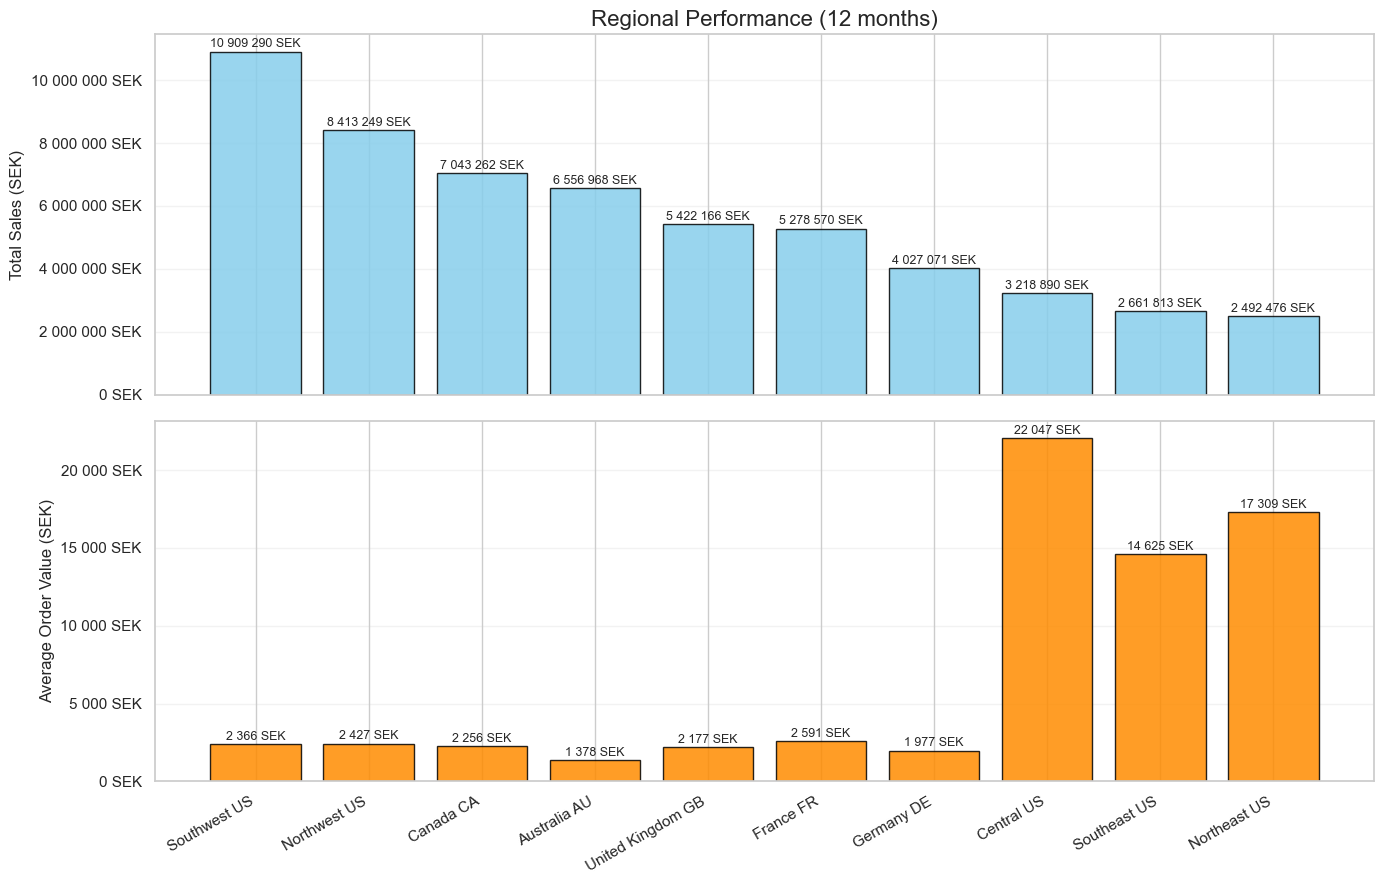

,Region,TotalSales,Orders,AvgOrderValue
0,Southwest US,1.090929e+07,4611,2365.9272
1,Northwest US,8.413249e+06,3467,2426.6653
2,Canada CA,7.043262e+06,3122,2256.0095
3,Australia AU,6.556968e+06,4758,1378.0932
4,United Kingdom GB,5.422166e+06,2491,2176.7025
5,France FR,5.278570e+06,2037,2591.3450
6,Germany DE,4.027071e+06,2037,1976.9618
7,Central US,3.218890e+06,146,22047.1888
8,Southeast US,2.661813e+06,182,14625.3488
9,Northeast US,2.492476e+06,144,17308.8607


In [43]:
sql = read_sql_file("visA3.sql")
dfA3 = query_df(sql)

dfA3 = dfA3.sort_values('TotalSales', ascending=False).reset_index(drop=True)

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(14, 9), sharex=True)

bars1 = ax1.bar(dfA3['Region'], dfA3['TotalSales'], color='skyblue', edgecolor='black', alpha=0.85)
ax1.set_title("Regional Performance (12 months)", fontsize=16)
ax1.set_ylabel("Total Sales (SEK)", fontsize=12)
ax1.yaxis.set_major_formatter(sek_formatter)
ax1.grid(axis='y', alpha=0.25)

for b in bars1:
    v = b.get_height()
    ax1.annotate(f"{int(round(v)):,.0f} SEK".replace(",", " "),
                 (b.get_x() + b.get_width() / 2, v),
                 textcoords="offset points",
                    xytext=(0,3),
                    ha='center', fontsize=9
                    )

bars2 = ax2.bar(dfA3['Region'], dfA3['AvgOrderValue'], color='darkorange', edgecolor='black', alpha=0.85)
ax2.set_ylabel("Average Order Value (SEK)", fontsize=12)
ax2.yaxis.set_major_formatter(sek_formatter)
ax2.grid(axis='y', alpha=0.25)

for b in bars2:
    v = b.get_height()
    ax2.annotate(f"{int(round(v)):,.0f} SEK".replace(",", " "),
                 (b.get_x() + b.get_width() / 2, v),
                 textcoords="offset points",
                    xytext=(0,3),
                    ha='center', fontsize=9
                    )
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

dfA3

## Insights
Both graphs above show distinct, clear differences between regions in terms of both total sales volume but also average order value (over the last 12 months).

With total sales of more than 10.9 million SEK, the **Soutwest US** is once again the best performing region. Northwest US and Canada CA are next. These areas have a moderate average order value and comparatively high sales volume, suggesting a solid and wide-ranging customers with regular purchases.

The **Central US, Southeast US and Northeast US** on the other hand exhibit much lower overall sales but extremely high average order values. This implies fewer but significantly larger orders, likely from commercial clients or bulk purchases from business customers are what propel sales in these areas.

Both sales volume and average order values are lower in areas like **Australia AU, Germany DE and the United Kingdom GB**. These regions may represent underperformning markets where demand is weaker or where customers tend to place smaller orders, or order elsewhere.

All things considered, the graph and analysis shows a distinct trade-off between order value and sales volume across all regions. High-volume regions benefit from scale and stability, while high average order value regions rely on fewer, more high value transactions.

From a regional optimzation perspective, high AOV but low volume regions could benefit from strategies aimed at increasing customer count, like ads or targeted advertisements. Meanwhile high volume regions may want focus on upselling and increasing average order sizes to further maximize revenue.

# Reflection - Regional Sales Optimization

### Why this in-depth analysis was selected

The Regional Sales Optimization analysis was selected to gain a depper understanding of how sales performance varies across all geographic regions. While the G-level analysis focused on voerall sales metrics and comparisons, this deep analysis sought to identify regional strengths and weaknesses and seasona, patterns that may support data-driven strategy decisions. 

The primary goal was to understand not only which regions perform the best, but why they do so. And how performance could potentially be improved in the weaker regions.

### Why aggregation was performed in SQL rather than pandas

Aggregation was primarliy perfomed in SQL for a number of reasons:
- The AdventureWorks database contains very large datasets (which make SQL aggregation more efficient and scalable).
- SQL eliminates needles data transfer to Python by enabling filtering, aggregating and summarizing data at the source.
- Performing big calculations such as total sales per region in SQL ensure consistent business logic and reproducible results.

Pandas was then used mainly for reshaping the data and for visualisation purposes, which is where it provides the most value.

### Why these visualization types were chosen

Different visualization types were selected based on what sort of data was being analyzed:
- Heatmaps were used to compare sales across regions and product categories simultaneously, whilst making dominant categories and underperforming combinations easy to identify and read.
- Line charts were chosen for seasonal and monthly sales analysis, as they are very good at showing clear trends and fluctuations/patterns over time.
- Bar charts were used to compare total sales and average order values across regions as they allow for direct comparisons between all the different regions. 

### How pivot tables helped identify patterns
Pivot tables was something new to me. It did play a key role in restructuring the SQL data from region and product categories to make possible:  
- Quickly identify which product categories dominate each region.
- Compare relative sales performance across regions within a single view/graph.
- Support the creation of heatmaps that visually highlight strong and weak combinations.
Without pivot tables, identifying some of these patterns would have required much more manual processing.

### Challenges encountered and how they were solved
I had several challenges making this notebook but i'll highlight some:  
- Inconsistent regional labeling( Southwest vs Southwest US) made reading comparisons difficult. This was solved by combining region name and country code using CONCAT in SQL.
- Overly complex charts with dual axes made reading certain charts very difficult. These were simplified into seperate charts to improve clarity and interpretation.
- Differences in aggregation logic (like time windows) made comparing stats easier. This was solved by clearly defining and consistently applying a 12-month period on all VG parts (although it's more like 11 months since the last month is incomplete).

### Recommendations
- High performing regions such as Southwest US and Northwest US should be prioritized for continued investment, marketing efforts and having inventory available.
- Regions with higher average order value but low sales volume show clear opportunities to grow revenue by increasing customer acquisition and purchase frequeny.
- Underperforming regions with both low valume and low average order value may require localized marketing strategies or product adjustments to fit those regions.
- Products that dominate across all regions (Bikes) should be leveraged further, while weaker categories may need reassesment or targeted promotions (Clothing etc).

### Final summary
#### Key findings:
- Sales performance varies significantly across regions.
- Bikes dominate sales across all regions, but especially in the strongest markets.
- Seasonal patterns are visible across regions, with visible peaks and declines.

#### Business recommendations
- Focus growth efforts on increasing the customer base in high order value but low total sales regions.
- To raise the average order value, bolster upselling tactics in high-volume areas.
- Make marketing, pricing and inventory decisions based on insights from projects like these where data is clearly shown.
- Monitor seasonal trends to optimizing the timing of promotions and compaigns.